In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import numpy as np
import uuid
import glob
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
import datetime
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
OUTPUT_CHANNELS = 2

TRAIN_DIR = "data/train_image"
TRAIN_MASK_DIR = "data/train_mask"
VAL_DIR = "data/val_image"
VAL_MASK_DIR = "data/val_mask"

TRAIN_PATH = "data/train_image/class_0"
TRAIN_MASK_PATH = "data/train_mask/class_0"
VAL_PATH = "data/val_image/class_0"
VAL_MASK_PATH = "data/val_mask/class_0"

In [9]:
# for image_name in glob.glob(os.path.join(TRAIN_PATH, "class_0", "*")):
#     old_name = image_name.split("/")[-1].replace(".jpg", "")
#     new_name = uuid.uuid4().hex
# #     print(image_name, image_name.replace(old_name, new_name))
# #     print(image_name.replace("train_image", "train_mask"), image_name.replace(old_name, new_name).replace("train_image", "train_mask"))
#     os.rename(image_name, image_name.replace(old_name, new_name))
#     os.rename(image_name.replace("train_image", "train_mask").replace("jpg", "png"), 
#               image_name.replace(old_name, new_name).replace("train_image", "train_mask").replace("jpg", "png"))

In [10]:
# for image_name in glob.glob(os.path.join(VAL_PATH, "class_0", "*")):
#     old_name = image_name.split("/")[-1].replace(".jpg", "")
#     new_name = uuid.uuid4().hex
# #     print(image_name, image_name.replace(old_name, new_name))
# #     print(image_name.replace("train_image", "train_mask"), image_name.replace(old_name, new_name).replace("train_image", "train_mask"))
#     os.rename(image_name, image_name.replace(old_name, new_name))
#     os.rename(image_name.replace("val_image", "val_mask").replace("jpg", "png"), 
#               image_name.replace(old_name, new_name).replace("val_image", "val_mask").replace("jpg", "png"))

## Data Generator

In [11]:
BATCH_SIZE = 64

In [12]:
TRAINSET_SIZE = len(glob.glob(os.path.join(TRAIN_PATH, "*.jpg")))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
VALSET_SIZE = len(glob.glob(os.path.join(VAL_PATH, "*.jpg")))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1896 images.
The Validation Dataset contains 475 images.


In [13]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "image", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [14]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_WIDTH, IMG_HEIGHT))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_WIDTH, IMG_HEIGHT))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_WIDTH, IMG_HEIGHT))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_WIDTH, IMG_HEIGHT))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [15]:
SEED = 1

In [16]:
train_dataset = tf.data.Dataset.list_files(os.path.join(TRAIN_PATH, "*.jpg"), seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(os.path.join(VAL_PATH, "*.jpg"), seed=SEED)
val_dataset =val_dataset.map(parse_image)

In [17]:
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [18]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

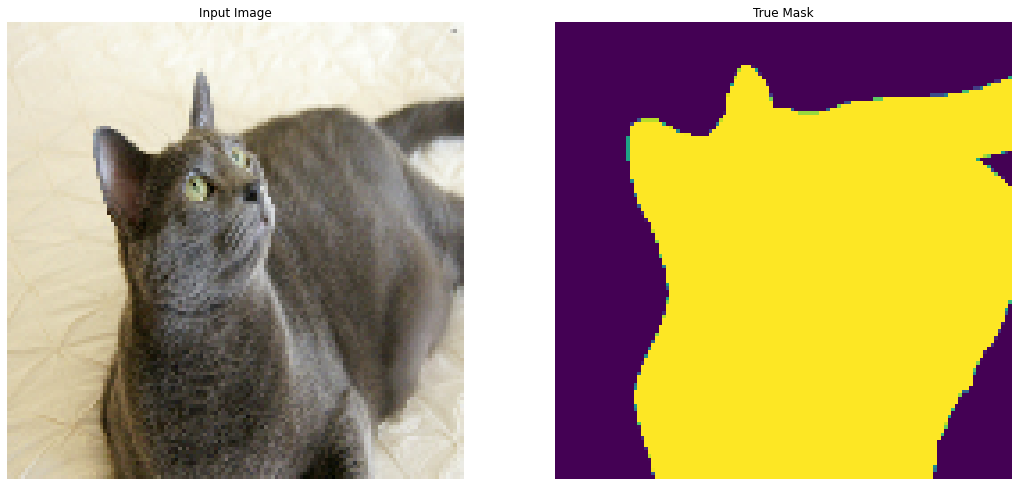

In [20]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

## U-net

In [48]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result


def build_model(output_channels):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=[128, 128, 3], include_top=False)
    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3,
        strides=2,
        padding='same',
        # activation='relu'
        # activation=tf.nn.sigmoid
    )  # 64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [49]:
model = build_model(OUTPUT_CHANNELS)

In [50]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [51]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 64, 64, 96), 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 512)    1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 8, 8, 1088)   0           sequential_4[0][0]               
                                                                 model_2[1][3]              

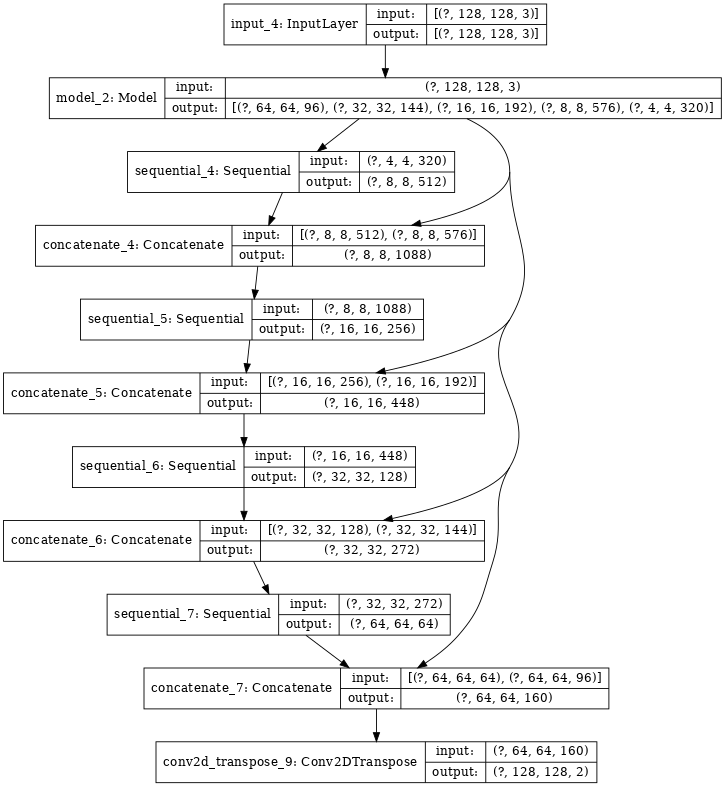

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

---
## Visualize <a class="anchor" id="vis"></a>

In [53]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)[0]])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

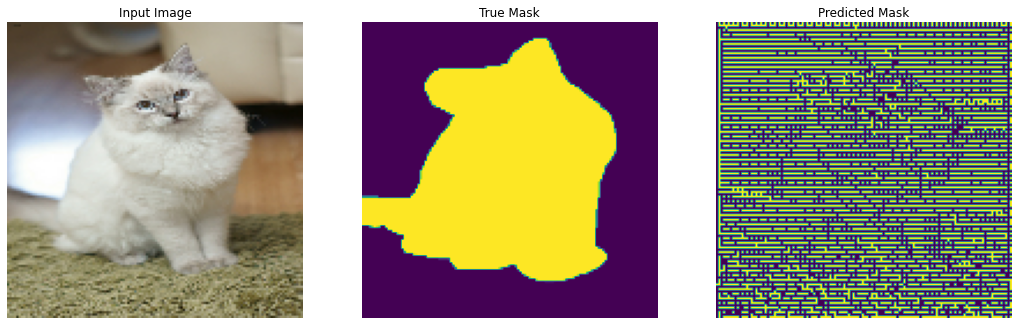

In [54]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

## Train

In [55]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [56]:
RES_DIR = "result"
MODEL_NAME = "unet_mobilenet_" + str(IMG_WIDTH) + "_" + str(EPOCH) +"epoch"
if not os.path.exists(os.path.join(RES_DIR, MODEL_NAME)):
    os.makedirs(os.path.join(RES_DIR, MODEL_NAME))

In [57]:
EPOCH = 100
TRAIN_STEP = TRAINSET_SIZE // BATCH_SIZE
VAL_STEP = VALSET_SIZE // BATCH_SIZE

In [58]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(RES_DIR, MODEL_NAME, "best_checkpoint.h5"), verbose=1, save_best_only=True)

In [59]:
callbacks = [
#     earlystopper, 
    checkpointer, 
    DisplayCallback()
]

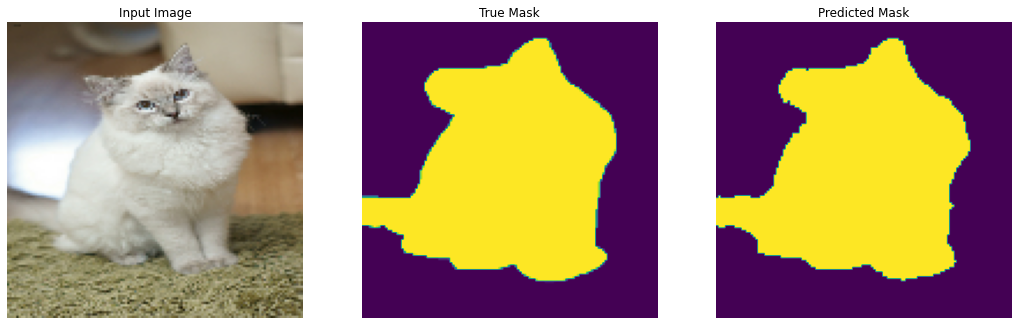


Sample Prediction after epoch 100

29/29 [==============================] - 6s 205ms/step - loss: 0.0219 - accuracy: 0.9847 - val_loss: 0.3325 - val_accuracy: 0.9336


In [60]:
model_history = model.fit(
    dataset['train'], 
    steps_per_epoch=TRAIN_STEP,
    
    validation_steps=VAL_STEP,
    validation_data=dataset['val'], 
    
    epochs=EPOCH,
    callbacks=callbacks
)

In [61]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(20, 12))
    # Acc
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'o-', label = "Train Acc")
    plt.plot(history.history['val_accuracy'], 'o-', label = "Val Acc")
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'o-', label = "Train Loss")
    plt.plot(history.history['val_loss'], 'o-', label = "Val Loss")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

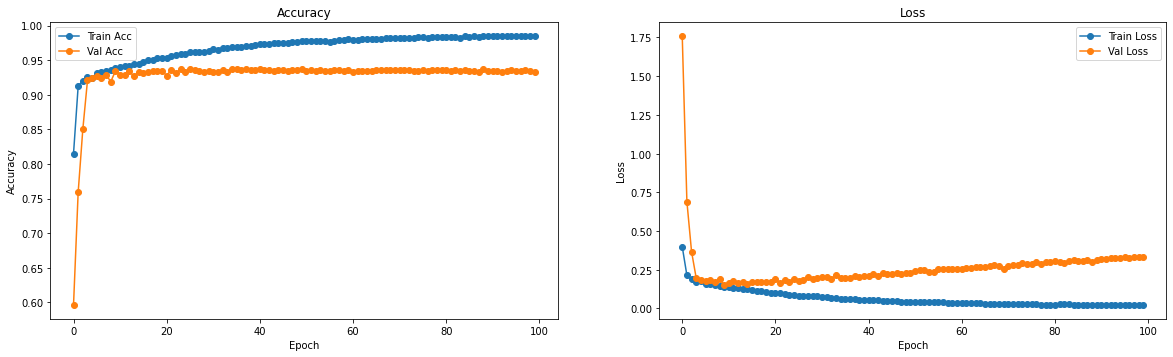

In [62]:
plot_accuracy_loss(model_history)
plt.show()

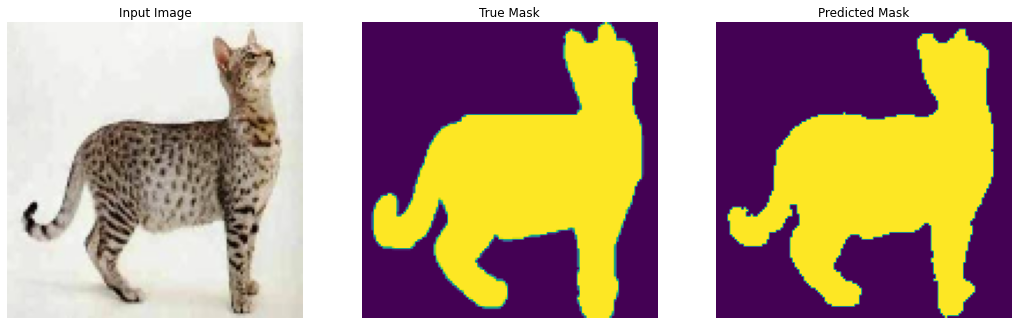

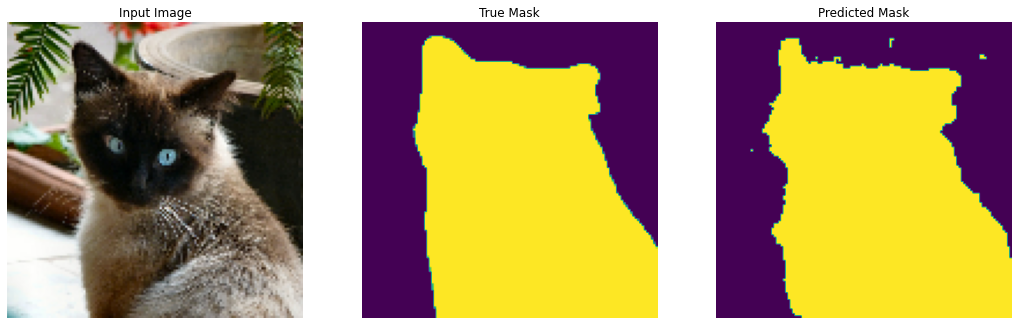

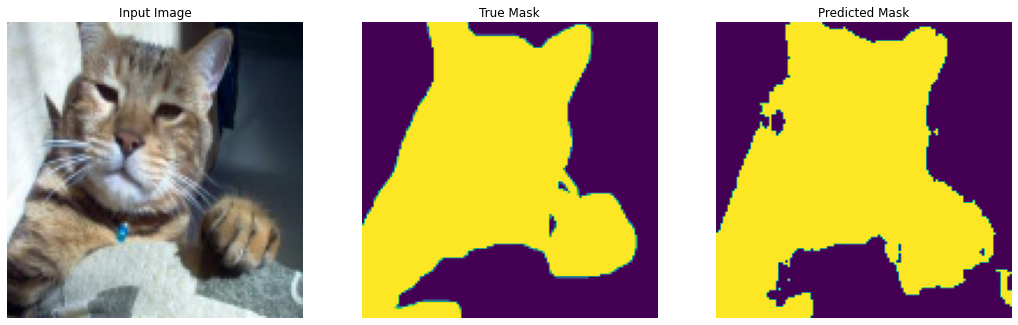

In [67]:
show_predictions(dataset['val'], 3)

In [70]:
plot_accuracy_loss(model_history)
plt.savefig(os.path.join(RES_DIR, MODEL_NAME, "acc_loss.png"))
plt.close()

In [69]:
model.save(os.path.join(RES_DIR, MODEL_NAME, "model.h5"))